In [1]:
from dotenv import load_dotenv
import pickle
import os

from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint, HuggingFacePipeline
from langchain.tools import tool
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages

from typing_extensions import TypedDict
from typing import Annotated

load_dotenv()  # Считываем креды

/home/tas/.cache/pypoetry/virtualenvs/ai-mas-hse-project-Nc-XwFR1-py3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
import torch

# Define the device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA (NVIDIA GPU) is available.")
elif torch.backends.mps.is_available(): # For Apple Silicon (M1/M2/M3)
    device = torch.device("mps")
    print("MPS (Apple Silicon GPU) is available.")
else:
    device = torch.device("cpu")
    print("No GPU found, running on CPU.")

print(f"Using device: {device}")

CUDA (NVIDIA GPU) is available.
Using device: cuda


In [3]:
# Данная команда позволяет очистить неиспользуемый кэш в GPU
# В моем случае, если я несколько раз инициализирую модель через HuggingFacePipeline, то у меня несколько раз задублируется память на GPU
# Если запустить команду torch.cuda.empty_cache() , то на GPU останется только один инстанс модели, а не несколько

torch.cuda.empty_cache() 

# Загружаем датасет с математическими задачами

In [4]:
with open("../data/final_dataset/list_dict_with_tasks.pkl", "rb") as file:
    list_json = pickle.load(file)

## Фиксируем одну конкретную задачу для тестирования бейзлайна

In [5]:
test_task = list_json[47]
test_task

{'id': 32838,
 'topic': 'Алгебра и арифметика',
 'subtopic': 'Задачи на движение',
 'complexity_level': '2',
 'problem': 'Вадим и Лёша спускались с горы. Вадим шёл пешком, а Лёша съезжал на лыжах в семь раз быстрее Вадима. На полпути Лёша упал, сломал лыжи и ногу и пошёл в два раза медленней Вадима. Кто первым спустится с горы?',
 'solution': 'Леша шёл пешком с половины горы столько же времени, сколько Вадим спускался с вершины.',
 'answer': 'Вадим'}

# Hugging Face. Инициализируем модель
* [Huggingface Endpoints](https://docs.langchain.com/oss/python/integrations/llms/huggingface_endpoint#dedicated-endpoint) - здесь описано как пользоваться `HF Endpoints`. Также приведены ссылки с информацией об `inference-providers`. В параграфе `Dedicated Endpoint` описано в каких случаях инференс через endpoint бесплатный, а в каких платный.
* [Inference Providers](https://huggingface.co/docs/inference-providers/index) - исчерпывающая информация о провайдерах.
* [Inference Cost](https://huggingface.co/settings/inference-providers/overview) - здесь показывается информация о том сколько запросов я сделал и с помощью какой LLM. Также показывается сколько денег я должен заплатить за произведенные запросы. Также тут можно посмотреть (переключив ползунок в положение Providers) услугами каких провайдеров я пользуюсь при выполнении запросов к LLM.
* [Billing](https://huggingface.co/settings/billing) - здесь можно посмотреть более подробную сводку о денежных счетах и их оплате. Согласно этой странице, дефолтный HuggingFaceEndpoint, который я использую ниже - бесплатный. Потому что в графе Inference Usage написано 0.00$.
    - Также тут написаны ограничения в графе Hub Rate Limits. Каждый раз, когда я обновляю страницу лимиты сокращаются. Непонимаю почему так, потому что API не пользуюсь в данный момент.
    - А, нет. Все нормально. Я ушел с этой страницы, а потом опять на нее зашел и все стало нормально. Нельзя превышать определенное число запросов за последние 5 минут. В остальном все бесплатно.
* [Inference Endpoints](https://endpoints.huggingface.co/) - сервис для платного инференса (соответственно с большими лимитами)

## HuggingFaceEndpoint
Обращаемся к модели через бесплатный API. Этот метод имеет ряд ограничений по вызовам к модели

In [ ]:
# llm = HuggingFaceEndpoint(
#     repo_id="deepseek-ai/DeepSeek-R1-0528",
#     task="text-generation",
#     max_new_tokens=512,
#     do_sample=False, # При do_sample=True становятся доступны параметры temperature, top_k, top_p
#     repetition_penalty=1.03,
#     provider="auto",  # let Hugging Face choose the best provider for you
# )

# hf_deepseek_model = ChatHuggingFace(llm=llm)

In [ ]:
# response = hf_deepseek_model.invoke("Calculate 3^3")
# print(response.content)

## HuggingFacePipeline
Данный метод скачивает модель на локальный компьютер по следующему пути: `/home/tas/.cache/huggingface/hub`
* Из плюсов: нет никаких ограничений. Все ограничения упираются в лимиты по ресурсам локального компьютера.
* Я выбрал самую легковесную модель: `TinyLlama/TinyLlama-1.1B-Chat-v1.0`. На GPU она занимает 4гб из 12гб.

In [ ]:
from langchain_huggingface import ChatHuggingFace, HuggingFacePipeline

llm = HuggingFacePipeline.from_model_id(
    model_id="TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    task="text-generation",
    device=0,
    
    pipeline_kwargs=dict(
        max_new_tokens=512,
        do_sample=False, # При do_sample=True становятся доступны параметры temperature, top_k, top_p
        repetition_penalty=1.03,
    ),
)

tiny_lama_model = ChatHuggingFace(llm=llm)
#tiny_lama_model_with_tools = tiny_lama_model.bind_tools([multiply]) # Привязываем Tools к LLM

In [ ]:
response = tiny_lama_model.invoke("Calculate 3^3")
print(response.content)

# Строим task_solver_llm

Модельки для тестирования запросов:
* `TinyLlama/TinyLlama-1.1B-Chat-v1.0` - мелкая, быстрая, но очень глупая
* `LiquidAI/LFM2-2.6B-Exp` - потяжелее, поумнее, помедленней и плоховато с русским языком
* `HuggingFaceTB/SmolLM3-3B` - не влезает
* `utter-project/EuroLLM-1.7B-Instruct`

In [ ]:
torch.cuda.empty_cache()

llm = HuggingFacePipeline.from_model_id(
    model_id="LiquidAI/LFM2-2.6B-Exp",
    task="text-generation",
    device=0,
    
    pipeline_kwargs=dict(
        max_new_tokens=8192,
        do_sample=False, # При do_sample=True становятся доступны параметры temperature, top_k, top_p
        repetition_penalty=1.03,
        ),
    ) 

tiny_lama_model = ChatHuggingFace(llm=llm)

In [ ]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [ ]:
# Node
def task_solver_llm(state: MessagesState):
    return {"messages": [tiny_lama_model.invoke(state["messages"])]}

In [ ]:
# Build graph
builder = StateGraph(MessagesState)
builder.add_node("task_solver_llm", task_solver_llm)

builder.add_edge(START, "task_solver_llm")
builder.add_edge("task_solver_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
test_task = list_json[47]
test_task

In [ ]:
##===========Инициализируем промты===========##
system_msg = SystemMessage(
"""
# Роль: ассистент, хорошо понимающий и разбирающийся в математике.

## Твоя задача помочь пользователю "Студент" решить задачу по математике.

## Твое решение должно содержать подробное рассуждение и шаги, которые ты предпринял, чтобы решить задачу. 

## Ты должен обходиться без длительных рассуждений. Вначале напиши план того, как ты будешь решать задачу. Далее действуй согласно описанному плану. Не уходи в бесконечные рассуждения.

## Ответ к задаче необходимо давать после описания решения к задаче в следующем формате: ответ должен находиться между "START_ANSWER" и "END_ANSWER". Т.е. это должно выглядеть следующим образом:

START_ANSWER "Ответ ассистента к задаче" (идет после решения) END_ANSWER

## Важно!!! Твой ответ должен быть коротким и четким и отвечать на вопрос исходной задачи.
""")

human_msg = HumanMessage(f"Привет, уважаемый ассистент! Я студент. Помоги мне, пожалуйста, решить следующую задачу: {test_task['problem']}", 
                        name="Студент")

# Use with chat models
messages = [system_msg, human_msg]

In [ ]:
torch.cuda.empty_cache()
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

In [ ]:
answer = messages['messages'][-1].content

start_marker = "START_ANSWER"
end_marker = "END_ANSWER"

start_idx = answer.rfind(start_marker) + len(start_marker)
end_idx = answer.rfind(end_marker)
assist_answer= answer[start_idx:end_idx].strip()
assist_answer

# Строим task_reviewer_llm

In [ ]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [ ]:
# Node
def task_solver_llm(state: MessagesState):
    return {"messages": [tiny_lama_model.invoke(state["messages"])]}

In [ ]:
# Build graph
builder = StateGraph(MessagesState)
builder.add_node("task_solver_llm", task_solver_llm)

builder.add_edge(START, "task_solver_llm")
builder.add_edge("task_solver_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
test_task = list_json[47]
test_task

In [ ]:
##===========Инициализируем промты===========##
system_msg_describe = SystemMessage(
f"""
# Роль: ассистент, проверяющий ответ другого ассистента.

## Твоя задача оценить правильность ответа АССИСТЕНТА №1 и сказать, правильно ли ассистент решил задачу или нет.

## Тебе на вход будет подаваться ответ АССИСТЕНТА №1, а также ground_truth ответ. Однако ground_truth ответ может иногда отсутствовать.

## В случае, если ground_truth ответ имеется, то тебе нужно сравнить ответ АССИСТЕНТА №1 и ground_truth ответ. 

## В случае, если В случае, если ground_truth ответ отсутствует, то тебе нужно сравнить ответ АССИСТЕНТА №1 и ground_truth ответ.

## В качестве ответа напиши "START_ANSWER ПРАВИЛЬНО END_ANSWER", если ответ АССИСТЕНТА №1 и ground_truth совпадают. 

## В качестве ответа напиши "START_ANSWER ОШИБКА END_ANSWER", если ответ АССИСТЕНТА №1 и ground_truth НЕ совпадают.

## ПИШИ В ОТВЕТЕ ТОЛЬКО "START_ANSWER ПРАВИЛЬНО END_ANSWER" и "START_ANSWER ОШИБКА END_ANSWER".

## Ты должен обходиться без длительных рассуждений. Твоя задача просто сравнить два ответа и сказать правильно ли АССИСТЕНТ №1 решил задачу или нет.
""")

system_msg_w_answer = HumanMessage(f"Ответ АССИСТЕНТА №1: {assist_answer}. ground_truth = {test_task['answer']}",
                                   name="АССИСТЕНТ №1")

# Use with chat models
messages = [system_msg_describe, system_msg_w_answer]

In [ ]:
torch.cuda.empty_cache()
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

# Объединяем task_solver_llm и task_reviewer_llm

In [6]:
torch.cuda.empty_cache()

llm = HuggingFacePipeline.from_model_id(
    model_id="LiquidAI/LFM2-2.6B-Exp",
    task="text-generation",
    device=0,
    pipeline_kwargs=dict(
        max_new_tokens=2000,
        do_sample=False,
        repetition_penalty=1,
    ),
)

tiny_lama_model = ChatHuggingFace(llm=llm)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]
Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [39]:
# Определяем состояние графа
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    ground_truth: str  # Добавляем поле для правильного ответа
    task_problem: str  # Добавляем поле для текста задачи
    solver_answer: str  # Поле для хранения ответа ассистента-решальщика
    reviewer_answer: str  # Поле для хранения ответа ассистента-проверяльщика
    review_result: int # Результат проверки решения ассистента ассесором. 1 - ответ ассистента правильный. 0 - ответ ассистента неправильный

In [40]:
def find_answer(ass_prompt: str,
                start_marker: str = "START_ANSWER",
                end_marker:str = "END_ANSWER"):
    # Извлекаем ответ из текста
    answer = ass_prompt
    
    start_idx = answer.rfind(start_marker)
    end_idx = answer.rfind(end_marker)
    
    if start_idx != -1 and end_idx != -1:
        start_idx += len(start_marker)
        extracted_answer = answer[start_idx:].strip(end_marker)
    else:
        extracted_answer = answer.strip()
    
    return extracted_answer

In [41]:
# Узел 1: Решение задачи
def task_solver_llm(state: MessagesState):
    # Промт для решения задачи
    system_msg = SystemMessage(
"""
# Роль: ассистент, хорошо понимающий и разбирающийся в математике.

## Твоя задача помочь пользователю "Студент" решить задачу по математике.

## Твое решение должно содержать подробное рассуждение и шаги, которые ты предпринял, чтобы решить задачу. 

## Ты должен обходиться без длительных рассуждений. Вначале напиши план того, как ты будешь решать задачу. Далее действуй согласно описанному плану. Не уходи в бесконечные рассуждения.

## Ответ к задаче необходимо давать после описания решения к задаче в следующем формате: ответ должен находиться между "START_ANSWER" и "END_ANSWER". Т.е. это должно выглядеть следующим образом:

START_ANSWER "Ответ ассистента к задаче" (идет после решения) END_ANSWER

## Важно!!! Твой ответ должен быть коротким и четким и отвечать на вопрос исходной задачи.
"""
    )
    
    human_msg = HumanMessage(
        f"Привет, уважаемый ассистент! Я студент. Помоги мне, пожалуйста, решить следующую задачу: {state['task_problem']}",
        name="Студент"
    )
    
    # Вызываем модель для решения задачи
    response = tiny_lama_model.invoke([system_msg, human_msg])
    
    # Извлекаем ответ из текста
    extracted_answer = find_answer(response.content)
    
    # Обновляем состояние
    return {
        "messages": [
            # system_msg, 
            # human_msg, 
            response
            ],
        "task_problem": state["task_problem"],
        "ground_truth": state["ground_truth"],
        "solver_answer": extracted_answer,
        "reviewer_answer": state['reviewer_answer'],
        "review_result": state['review_result']
    }

# Узел 2: Проверка решения
def task_reviewer_llm(state: MessagesState):
    # Промт для проверки
    system_msg_describe = SystemMessage(
"""
# Роль: ассистент, проверяющий ответ другого ассистента.

## Твоя задача оценить правильность ответа АССИСТЕНТА №1 и сказать, правильно ли ассистент решил задачу или нет.

## Тебе на вход будет подаваться ответ АССИСТЕНТА №1, а также ground_truth ответ. 

## Сравни ответ АССИСТЕНТА №1 и ground_truth ответ. 

## В качестве ответа напиши "START_ANSWER ПРАВИЛЬНО END_ANSWER", если ответ АССИСТЕНТА №1 и ground_truth совпадают.

## В качестве ответа напиши "START_ANSWER ОШИБКА END_ANSWER", если ответ АССИСТЕНТА №1 и ground_truth НЕ совпадают.

## Если ground_truth отсутствует, то делай выводы на основании собственный умений и знаний. Но даже в этом случае старайся избегать длинных рассуждений. Говори четко и по делу. 

## ПИШИ В ОТВЕТЕ ТОЛЬКО "START_ANSWER ПРАВИЛЬНО END_ANSWER" или "START_ANSWER ОШИБКА END_ANSWER".

## Ты должен обходиться без длительных рассуждений. Твоя задача просто сравнить два ответа и сказать правильно ли АССИСТЕНТ №1 решил задачу или нет.
"""
    )
    
    human_msg = HumanMessage(
        f"Ответ АССИСТЕНТА №1: {state['reviewer_answer']}. ground_truth = {state['ground_truth']}",
        name="АССИСТЕНТ №1"
    )
    
    # Вызываем модель для проверки
    response = tiny_lama_model.invoke([system_msg_describe, human_msg])

    extracted_answer = find_answer(response.content).lower()

    review_result = 1 if "правильно" in extracted_answer else 0
    
    # Добавляем сообщение в историю
    return {"messages": [response],
            "task_problem": state["task_problem"],
            "ground_truth": state["ground_truth"],
            "solver_answer": state["solver_answer"],
            "reviewer_answer": extracted_answer,
            "review_result": review_result
    }

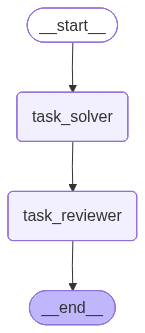

In [42]:
builder = StateGraph(MessagesState)

# Добавляем узлы
builder.add_node("task_solver", task_solver_llm)
builder.add_node("task_reviewer", task_reviewer_llm)

# Определяем связи между узлами
builder.add_edge(START, "task_solver")
builder.add_edge("task_solver", "task_reviewer")
builder.add_edge("task_reviewer", END)

# Компилируем граф
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [46]:
# Тестирование
test_task = list_json[0]  # Ваша тестовая задача

ground_truth_problem = test_task['problem']
ground_truth_answer = test_task['answer']

test_task

{'id': 115968,
 'topic': 'Алгебра и арифметика',
 'subtopic': 'Исследование квадратного трехчлена',
 'complexity_level': '2+',
 'problem': 'Известно, что разность кубов корней квадратного уравнения ax ² + bx + c = 0 равна 2011. Сколько корней имеет уравнение ax ² + 2 bx + 4 c = 0?',
 'solution': 'Из условия следует, что первое уравнение имеет два корня. Следовательно, его дискриминант D = b ² – 4 ac &gt; 0. Упрощенный дискриминант второго уравнения также равен b ² – 4 ac , значит, оно также имеет два корня.',
 'answer': 'Два корня'}

In [47]:
# Запускаем граф
torch.cuda.empty_cache()

# Подготавливаем начальное состояние
initial_state = {
    "messages": [],
    "task_problem": ground_truth_problem,
    "ground_truth": ground_truth_answer,
    "solver_answer": "",
    "reviewer_answer": "",
    "review_result": None
}

result = graph.invoke(initial_state)

In [48]:
result

{'messages': [AIMessage(content='<|startoftext|><|im_start|>system\n\n# Роль: ассистент, хорошо понимающий и разбирающийся в математике.\n\n## Твоя задача помочь пользователю "Студент" решить задачу по математике.\n\n## Твое решение должно содержать подробное рассуждение и шаги, которые ты предпринял, чтобы решить задачу. \n\n## Ты должен обходиться без длительных рассуждений. Вначале напиши план того, как ты будешь решать задачу. Далее действуй согласно описанному плану. Не уходи в бесконечные рассуждения.\n\n## Ответ к задаче необходимо давать после описания решения к задаче в следующем формате: ответ должен находиться между "START_ANSWER" и "END_ANSWER". Т.е. это должно выглядеть следующим образом:\n\nSTART_ANSWER "Ответ ассистента к задаче" (идет после решения) END_ANSWER\n\n## Важно!!! Твой ответ должен быть коротким и четким и отвечать на вопрос исходной задачи.\n<|im_end|>\n<|im_start|>user\nПривет, уважаемый ассистент! Я студент. Помоги мне, пожалуйста, решить следующую задачу:

In [49]:
for i in result['messages']:
    i.pretty_print()

================================== Ai Message ==================================

<|startoftext|><|im_start|>system

# Роль: ассистент, хорошо понимающий и разбирающийся в математике.

## Твоя задача помочь пользователю "Студент" решить задачу по математике.

## Твое решение должно содержать подробное рассуждение и шаги, которые ты предпринял, чтобы решить задачу. 

## Ты должен обходиться без длительных рассуждений. Вначале напиши план того, как ты будешь решать задачу. Далее действуй согласно описанному плану. Не уходи в бесконечные рассуждения.

## Ответ к задаче необходимо давать после описания решения к задаче в следующем формате: ответ должен находиться между "START_ANSWER" и "END_ANSWER". Т.е. это должно выглядеть следующим образом:

START_ANSWER "Ответ ассистента к задаче" (идет после решения) END_ANSWER

## Важно!!! Твой ответ должен быть коротким и четким и отвечать на вопрос исходной задачи.
<|im_end|>
<|im_start|>user
Привет, уважаемый ассистент! Я студент. Помоги мне, пожа

# Рассчет Success Rate

In [ ]:
# Собираем результаты LLM по всем задачам

tasks_results = []

for i_task_id_in_list, i_task in enumerate(list_json[:]):
    # Подготавливаем начальное состояние
    initial_state = {
        "messages": [],
        "task_problem": i_task['problem'],
        "ground_truth": i_task['answer'],
        "solver_answer": "",
        "reviewer_answer": "",
        "review_result": None
    }

    # Запускаем граф
    torch.cuda.empty_cache()

    result = graph.invoke(initial_state)
    result['index_list'] = i_task_id_in_list

    tasks_results.append(result)


In [ ]:
# Считаем SR

cnt_all = len(tasks_results)
cnt_success = 0

for i_task in tasks_results:
    if i_task['review_result'] == 1:
        cnt_success +=1

success_rate = round(cnt_success / cnt_all, 2)

print(f"Всего задач: {cnt_all}")
print(f"Решены ассистентом верно: {cnt_success}")
print(f"Success Rate: {success_rate}")


Всего задач: 147
Решены ассистентом верно: 51
Success Rate: 0.35


In [ ]:
# Сохраняем результаты запросов к LLM в .pkl формат
with open("../data/llm_results/tasks_result_liquidai_06_01_2025.pkl", "wb") as file:
    pickle.dump(tasks_results, file)

In [54]:
_idx = 6

tasks_results[_idx]['messages'][-1].pretty_print(), tasks_results[_idx]['task_problem'], tasks_results[_idx]['ground_truth'],  tasks_results[_idx]['review_result']

================================== Ai Message ==================================

<|startoftext|><|im_start|>system

# Роль: ассистент, проверяющий ответ другого ассистента.

## Твоя задача оценить правильность ответа АССИСТЕНТА №1 и сказать, правильно ли ассистент решил задачу или нет.

## Тебе на вход будет подаваться ответ АССИСТЕНТА №1, а также ground_truth ответ. 

## Сравни ответ АССИСТЕНТА №1 и ground_truth ответ. 

## В качестве ответа напиши "START_ANSWER ПРАВИЛЬНО END_ANSWER", если ответ АССИСТЕНТА №1 и ground_truth совпадают.

## В качестве ответа напиши "START_ANSWER ОШИБКА END_ANSWER", если ответ АССИСТЕНТА №1 и ground_truth НЕ совпадают.

## Если ground_truth отсутствует, то делай выводы на основании собственный умений и знаний.

## ПИШИ В ОТВЕТЕ ТОЛЬКО "START_ANSWER ПРАВИЛЬНО END_ANSWER" или "START_ANSWER ОШИБКА END_ANSWER".

## Ты должен обходиться без длительных рассуждений. Твоя задача просто сравнить два ответа и сказать правильно ли АССИСТЕНТ №1 решил задачу или нет

(None,
 ' Вычислите следующие произведения: а) <!-- MATH $\\sin20^{\\circ}\\sin40^{\\circ}\\sin60^{\\circ}\\sin80^{\\circ}$ --> sin 20<sup><tt>o</tt></sup>sin 40<sup><tt>o</tt></sup>sin 60<sup><tt>o</tt></sup>sin 80<sup><tt>o</tt></sup>; б) <!-- MATH $\\cos20^{\\circ}\\cos40^{\\circ}\\cos60^{\\circ}\\cos80^{\\circ}$ --> cos 20<sup><tt>o</tt></sup>cos 40<sup><tt>o</tt></sup>cos 60<sup><tt>o</tt></sup>cos 80<sup><tt>o</tt></sup>.',
 'а) 3/16; б) 1/16',
 0)

In [33]:
tasks_results

[{'messages': [AIMessage(content='<|startoftext|><|im_start|>system\n\n# Роль: ассистент, хорошо понимающий и разбирающийся в математике.\n\n## Твоя задача помочь пользователю "Студент" решить задачу по математике.\n\n## Твое решение должно содержать подробное рассуждение и шаги, которые ты предпринял, чтобы решить задачу. \n\n## Ты должен обходиться без длительных рассуждений. Вначале напиши план того, как ты будешь решать задачу. Далее действуй согласно описанному плану. Не уходи в бесконечные рассуждения.\n\n## Ответ к задаче необходимо давать после описания решения к задаче в следующем формате: ответ должен находиться между "START_ANSWER" и "END_ANSWER". Т.е. это должно выглядеть следующим образом:\n\nSTART_ANSWER "Ответ ассистента к задаче" (идет после решения) END_ANSWER\n\n## Важно!!! Твой ответ должен быть коротким и четким и отвечать на вопрос исходной задачи.\n<|im_end|>\n<|im_start|>user\nПривет, уважаемый ассистент! Я студент. Помоги мне, пожалуйста, решить следующую задачу

--------------
--------------
--------------
--------------